In [33]:
from IPython.display import display, HTML
from pyspark.sql import SparkSession
from pyspark import StorageLevel
import pandas as pd
from pyspark.sql.types import StructType, StructField,StringType, LongType, IntegerType, DoubleType, ArrayType
from pyspark.sql.functions import regexp_replace
from sedona.register import SedonaRegistrator
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from pyspark.sql.functions import col, split, expr
from pyspark.sql.functions import udf, lit
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from pyspark.sql.functions import col, split, expr
from pyspark.sql.functions import udf, lit


# Create Spark Session for application

In [34]:
spark = SparkSession.\
    builder.\
    master("local[*]").\
    appName("Demo-app").\
    config("spark.serializer", KryoSerializer.getName).\
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName) .\
    config("spark.jars.packages", "org.apache.sedona:sedona-python-adapter-3.0_2.12:1.1.0-incubating,org.datasyslab:geotools-wrapper:1.1.0-25.2") .\
    getOrCreate()

SedonaRegistrator.registerAll(spark)
sc = spark.sparkContext


21/10/08 19:55:41 WARN UDTRegistration: Cannot register UDT for org.locationtech.jts.geom.Geometry, which is already registered.
21/10/08 19:55:41 WARN UDTRegistration: Cannot register UDT for org.locationtech.jts.index.SpatialIndex, which is already registered.
21/10/08 19:55:41 WARN SimpleFunctionRegistry: The function st_pointfromtext replaced a previously registered function.
21/10/08 19:55:41 WARN SimpleFunctionRegistry: The function st_polygonfromtext replaced a previously registered function.
21/10/08 19:55:41 WARN SimpleFunctionRegistry: The function st_linestringfromtext replaced a previously registered function.
21/10/08 19:55:41 WARN SimpleFunctionRegistry: The function st_geomfromtext replaced a previously registered function.
21/10/08 19:55:41 WARN SimpleFunctionRegistry: The function st_geomfromwkt replaced a previously registered function.
21/10/08 19:55:41 WARN SimpleFunctionRegistry: The function st_geomfromwkb replaced a previously registered function.
21/10/08 19:55:

# Geotiff Loader 

1. Loader takes as input a path to directory which contains geotiff files or a parth to particular geotiff file
2. Loader will read geotiff image in a struct named image which contains multiple fields as shown in the schema below which can be extracted using spark SQL

In [35]:
# Path to directory of geotiff images 
DATA_DIR = "./data/raster/"

In [36]:
df = spark.read.format("geotiff").option("dropInvalid",True).load(DATA_DIR)
df.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- wkt: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nBands: integer (nullable = true)
 |    |-- data: array (nullable = true)
 |    |    |-- element: double (containsNull = true)



In [37]:
df = df.selectExpr("image.origin as origin","ST_GeomFromWkt(image.wkt) as Geom", "image.height as height", "image.width as width", "image.data as data", "image.nBands as bands")
df.show(5)

+--------------------+--------------------+------+-----+--------------------+-----+
|              origin|                Geom|height|width|                data|bands|
+--------------------+--------------------+------+-----+--------------------+-----+
|file:///Users/jia...|POLYGON ((-58.702...|    32|   32|[1081.0, 1068.0, ...|    4|
|file:///Users/jia...|POLYGON ((-58.286...|    32|   32|[1151.0, 1141.0, ...|    4|
+--------------------+--------------------+------+-----+--------------------+-----+



# Extract a particular band from geotiff dataframe using RS_GetBand()


In [38]:
''' RS_GetBand() will fetch a particular band from given data array which is the concatination of all the bands'''

df = df.selectExpr("Geom","RS_GetBand(data, 1,bands) as Band1","RS_GetBand(data, 2,bands) as Band2","RS_GetBand(data, 3,bands) as Band3", "RS_GetBand(data, 4,bands) as Band4")
df.createOrReplaceTempView("allbands")
df.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                Geom|               Band1|               Band2|               Band3|               Band4|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|POLYGON ((-58.702...|[1081.0, 1068.0, ...|[865.0, 1084.0, 1...|[0.0, 0.0, 0.0, 0...|[0.0, 0.0, 0.0, 0...|
|POLYGON ((-58.286...|[1151.0, 1141.0, ...|[1197.0, 1163.0, ...|[0.0, 0.0, 0.0, 0...|[0.0, 0.0, 0.0, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+



# Map Algebra operations on band values 

In [39]:
''' RS_NormalizedDifference can be used to calculate NDVI for a particular geotiff image since it uses same computational formula as ndvi'''

NomalizedDifference = df.selectExpr("RS_NormalizedDifference(Band1, Band2) as normDiff")
NomalizedDifference.show(5)

+--------------------+
|            normDiff|
+--------------------+
|[-0.11, 0.01, 0.0...|
|[0.02, 0.01, -0.0...|
+--------------------+



In [40]:
''' RS_Mean() can used to calculate mean of piel values in a particular spatial band '''
meanDF = df.selectExpr("RS_Mean(Band1) as mean")
meanDF.show(5)

+-------+
|   mean|
+-------+
|1153.85|
|1293.77|
+-------+



In [41]:
""" RS_Mode() is used to calculate mode in an array of pixels and returns a array of double with size 1 in case of unique mode"""
modeDF = df.selectExpr("RS_Mode(Band1) as mode")
modeDF.show(5)

+----------------+
|            mode|
+----------------+
| [1011.0, 927.0]|
|[1176.0, 1230.0]|
+----------------+



In [42]:
''' RS_GreaterThan() is used to mask all the values with 1 which are greater than a particular threshold'''
greaterthanDF = spark.sql("Select RS_GreaterThan(Band1,1000.0) as greaterthan from allbands")
greaterthanDF.show()

+--------------------+
|         greaterthan|
+--------------------+
|[1.0, 1.0, 1.0, 0...|
|[1.0, 1.0, 1.0, 1...|
+--------------------+



In [43]:
''' RS_GreaterThanEqual() is used to mask all the values with 1 which are greater than a particular threshold'''

greaterthanEqualDF = spark.sql("Select RS_GreaterThanEqual(Band1,360.0) as greaterthanEqual from allbands")
greaterthanEqualDF.show()

+--------------------+
|    greaterthanEqual|
+--------------------+
|[1.0, 1.0, 1.0, 1...|
|[1.0, 1.0, 1.0, 1...|
+--------------------+



In [44]:
''' RS_LessThan() is used to mask all the values with 1 which are less than a particular threshold'''
lessthanDF = spark.sql("Select RS_LessThan(Band1,1000.0) as lessthan from allbands")
lessthanDF.show()

+--------------------+
|            lessthan|
+--------------------+
|[0.0, 0.0, 0.0, 1...|
|[0.0, 0.0, 0.0, 0...|
+--------------------+



In [45]:
''' RS_LessThanEqual() is used to mask all the values with 1 which are less than equal to a particular threshold'''
lessthanEqualDF = spark.sql("Select RS_LessThanEqual(Band1,2890.0) as lessthanequal from allbands")
lessthanEqualDF.show()

+--------------------+
|       lessthanequal|
+--------------------+
|[1.0, 1.0, 1.0, 1...|
|[1.0, 1.0, 1.0, 1...|
+--------------------+



In [46]:
''' RS_AddBands() can add two spatial bands together'''
sumDF = df.selectExpr("RS_AddBands(Band1, Band2) as sumOfBand")
sumDF.show(5)

+--------------------+
|           sumOfBand|
+--------------------+
|[1946.0, 2152.0, ...|
|[2348.0, 2304.0, ...|
+--------------------+



In [47]:
''' RS_SubtractBands() can subtract two spatial bands together'''
subtractDF = df.selectExpr("RS_SubtractBands(Band1, Band2) as diffOfBand")
subtractDF.show(5)

+--------------------+
|          diffOfBand|
+--------------------+
|[-216.0, 16.0, 11...|
|[46.0, 22.0, -96....|
+--------------------+



In [48]:
''' RS_MultiplyBands() can multiple two bands together'''
multiplyDF = df.selectExpr("RS_MultiplyBands(Band1, Band2) as productOfBand")
multiplyDF.show(5)

+--------------------+
|       productOfBand|
+--------------------+
|[935065.0, 115771...|
|[1377747.0, 13269...|
+--------------------+



In [49]:
''' RS_DivideBands() can divide two bands together'''
divideDF = df.selectExpr("RS_DivideBands(Band1, Band2) as divisionOfBand")
divideDF.show(5)

+--------------------+
|      divisionOfBand|
+--------------------+
|[1.25, 0.99, 0.9,...|
|[0.96, 0.98, 1.08...|
+--------------------+



In [50]:
''' RS_MultiplyFactor() will multiply a factor to a spatial band'''
mulfacDF = df.selectExpr("RS_MultiplyFactor(Band2, 2) as target")
mulfacDF.show(5)

+--------------------+
|              target|
+--------------------+
|[1730.0, 2168.0, ...|
|[2394.0, 2326.0, ...|
+--------------------+



In [51]:
''' RS_BitwiseAND() will return AND between two values of Bands'''
bitwiseAND = df.selectExpr("RS_BitwiseAND(Band1, Band2) as AND")
bitwiseAND.show(5)

+--------------------+
|                 AND|
+--------------------+
|[33.0, 1068.0, 10...|
|[1069.0, 1025.0, ...|
+--------------------+



In [52]:
''' RS_BitwiseOR() will return OR between two values of Bands'''
bitwiseOR = df.selectExpr("RS_BitwiseOR(Band1, Band2) as OR")
bitwiseOR.show(5)

+--------------------+
|                  OR|
+--------------------+
|[1913.0, 1084.0, ...|
|[1279.0, 1279.0, ...|
+--------------------+



In [53]:
''' RS_Count() will calculate the total number of occurence of a target value'''
countDF = df.selectExpr("RS_Count(RS_GreaterThan(Band1,1000.0), 1.0) as count")
countDF.show(5)

+-----+
|count|
+-----+
|  753|
| 1017|
+-----+



In [54]:
''' RS_Modulo() will calculate the modulus of band value with respect to a given number'''
moduloDF = df.selectExpr("RS_Modulo(Band1, 21.0) as modulo ")
moduloDF.show(5)

+--------------------+
|              modulo|
+--------------------+
|[10.0, 18.0, 18.0...|
|[17.0, 7.0, 2.0, ...|
+--------------------+



In [55]:
''' RS_SquareRoot() will calculate calculate square root of all the band values upto two decimal places'''
rootDF = df.selectExpr("RS_SquareRoot(Band1) as root")
rootDF.show(5)


+--------------------+
|                root|
+--------------------+
|[32.88, 32.68, 32...|
|[33.93, 33.78, 35...|
+--------------------+



In [56]:
''' RS_LogicalDifference() will return value from band1 if value at that particular location is not equal tp band1 else it will return 0'''
logDiff = df.selectExpr("RS_LogicalDifference(Band1, Band2) as loggDifference")
logDiff.show(5)

+--------------------+
|      loggDifference|
+--------------------+
|[1081.0, 1068.0, ...|
|[1151.0, 1141.0, ...|
+--------------------+



In [57]:
''' RS_LogicalOver() will iterate over two bands and return value of first band if it is not equal to 0 else it will return value from later band'''
logOver = df.selectExpr("RS_LogicalOver(Band3, Band2) as logicalOver")
logOver.show(5)

+--------------------+
|         logicalOver|
+--------------------+
|[865.0, 1084.0, 1...|
|[1197.0, 1163.0, ...|
+--------------------+



# Visualising Geotiff Images

1. Normalize the bands in range [0-255] if values are greater than 255
2. Process image using RS_Base64() which converts in into a base64 string
3. Embedd results of RS_Base64() in RS_HTML() to embedd into IPython notebook
4. Process results of RS_HTML() as below:

In [58]:
''' Plotting images as a dataframe using geotiff Dataframe.'''

df = spark.read.format("geotiff").option("dropInvalid",True).load(DATA_DIR)
df = df.selectExpr("image.origin as origin","ST_GeomFromWkt(image.wkt) as Geom", "image.height as height", "image.width as width", "image.data as data", "image.nBands as bands")

df = df.selectExpr("RS_GetBand(data,1,bands) as targetband", "height", "width", "bands", "Geom")
df_base64 = df.selectExpr("Geom", "RS_Base64(height,width,RS_Normalize(targetBand), RS_Array(height*width,0.0), RS_Array(height*width, 0.0)) as red","RS_Base64(height,width,RS_Array(height*width, 0.0), RS_Normalize(targetBand), RS_Array(height*width, 0.0)) as green", "RS_Base64(height,width,RS_Array(height*width, 0.0),  RS_Array(height*width, 0.0), RS_Normalize(targetBand)) as blue","RS_Base64(height,width,RS_Normalize(targetBand), RS_Normalize(targetBand),RS_Normalize(targetBand)) as RGB" )
df_HTML = df_base64.selectExpr("Geom","RS_HTML(red) as RedBand","RS_HTML(blue) as BlueBand","RS_HTML(green) as GreenBand", "RS_HTML(RGB) as CombinedBand")
df_HTML.show(5)

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                Geom|             RedBand|            BlueBand|           GreenBand|        CombinedBand|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|POLYGON ((-58.702...|<img src="data:im...|<img src="data:im...|<img src="data:im...|<img src="data:im...|
|POLYGON ((-58.286...|<img src="data:im...|<img src="data:im...|<img src="data:im...|<img src="data:im...|
+--------------------+--------------------+--------------------+--------------------+--------------------+



,Geom,RedBand,BlueBand,GreenBand,CombinedBand
0,"POLYGON ((-58.70271939504448 -34.41877544555479, -58.70277605822864 -34.42156988068061, -58.6994039180242 -34.42161679331493, -58.69934736692278 -34.4188223533111, -58.70271939504448 -34.41877544555479))",,,,
1,"POLYGON ((-58.28663657626114 -34.75858090620287, -58.28667994174946 -34.76137571668496, -58.28329340123002 -34.76141146033393, -58.28325014980316 -34.75861664615162, -58.28663657626114 -34.75858090620287))",,,,

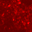
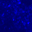
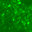
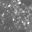
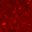
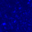
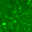
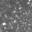

In [59]:
display(HTML(df_HTML.limit(2).toPandas().to_html(escape=False)))

# User can also create some UDF manually to manipulate Geotiff dataframes

In [60]:
''' Sample UDF calculates sum of all the values in a band which are greater than 1000.0 '''

def SumOfValues(band):
    total = 0.0
    for num in band:
        if num>1000.0:
            total+=1
    return total
    
calculateSum = udf(SumOfValues, DoubleType())
spark.udf.register("RS_Sum", calculateSum)

sumDF = df.selectExpr("RS_Sum(targetband) as sum")
sumDF.show()

+------+
|   sum|
+------+
| 753.0|
|1017.0|
+------+



21/10/08 19:55:44 WARN SimpleFunctionRegistry: The function rs_sum replaced a previously registered function.


21/10/08 19:55:44 WARN SimpleFunctionRegistry: The function rs_maskvalues replaced a previously registered function.


,Geom,selectedregion
0,"POLYGON ((-58.70271939504448 -34.41877544555479, -58.70277605822864 -34.42156988068061, -58.6994039180242 -34.42161679331493, -58.69934736692278 -34.4188223533111, -58.70271939504448 -34.41877544555479))",
1,"POLYGON ((-58.28663657626114 -34.75858090620287, -58.28667994174946 -34.76137571668496, -58.28329340123002 -34.76141146033393, -58.28325014980316 -34.75861664615162, -58.28663657626114 -34.75858090620287))",

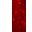
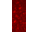

In [61]:
''' Sample UDF to visualize a particular region of a GeoTiff image'''

def generatemask(band, width,height):
    for (i,val) in enumerate(band):
        if (i%width>=12 and i%width<26) and (i%height>=12 and i%height<26):
            band[i] = 255.0
        else:
            band[i] = 0.0
    return band

maskValues = udf(generatemask, ArrayType(DoubleType()))
spark.udf.register("RS_MaskValues", maskValues)


df_base64 = df.selectExpr("Geom", "RS_Base64(height,width,RS_Normalize(targetband), RS_Array(height*width,0.0), RS_Array(height*width, 0.0), RS_MaskValues(targetband,width,height)) as region" )
df_HTML = df_base64.selectExpr("Geom","RS_HTML(region) as selectedregion")
display(HTML(df_HTML.limit(2).toPandas().to_html(escape=False)))
